![](img/330-banner.png)

# Lecture 20: Survival analysis 

UBC 2023-24

Instructor: Varada Kolhatkar and Andrew Roth

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import (
    cross_val_predict,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
import sys
import os

sys.path.append(os.path.join(os.path.abspath("."), "code"))
from utils import *

plt.rcParams["font.size"] = 12

# does lifelines try to mess with this?
pd.options.display.max_rows = 10

import warnings
warnings.filterwarnings('default')

In [2]:
import lifelines

## Learning objectives

- Explain what is right-censored data. 
- Explain the problem with treating right-censored data the same as "regular" data.
- Determine whether survival analysis is an appropriate tool for a given problem.
- Apply survival analysis in Python using the `lifelines` package.
- Interpret a survival curve, such as the Kaplan-Meier curve.
- Interpret the coefficients of a fitted Cox proportional hazards model.
- Make predictions for existing individuals and interpret these predictions.

## ❓❓ Questions for you

### (iClicker) Exercise 20.1 

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) We need to be careful when splitting the data when working with time series data. 
- (B) Cross-validation in time series can be randomly applied like in other machine learning tasks.
- (C) In time series forecasting, the future value of a series can only be predicted based on its past values and cannot incorporate other variables.
- (D) When we used `RandomForestRegressor` model on the POSIX time feature, it predicted a straight line on the test data because tree-based models are inherently unable to extrapolate (i.e., make predictions outside the range of the training data).   

## Recap 

- Time series analysis is used when there is a temporal aspect in the data
- **Data splitting**: Data should be split based on time to avoid future data leaking into the training set.
- **Essential questions for Exploratory Data Analysis (EDA)**:
    - How many time series are present within the dataset?
    - What is the frequency of data collection (e.g., hourly, daily)?
    - Are there any gaps or missing values in the data?
- **Feature engineering**
    - Derived new features from the date/time column.
    - Appropriately encoded features based on the chosen model.
    - Created lag features to incorporate past values for prediction.
- **Baseline model approach**: Employ a simple model, such as using today's target value to predict tomorrow's, as a starting point for comparison.
- **Cross-Validation Method for Time Series**: In `sklearn`, use `TimeSeriesSplit` as the `cv` parameter in functions like `cross_validate` or `cross_val_score` for time-appropriate validation.
- **Strategies for long-term forecasting**:
    - Generate forecasts for sequential time steps by assuming the predictions for the previous steps are accurate. 
- **Trends** 
    - A 'days since' feature to capture the trend over time

<br><br><br><br>

## Customer churn

- Customer churn, also known as customer attrition, refers to the phenomenon where customers or subscribers stop doing business with a company or service.
- The bar-chart below is showing the monthly subscriber churn rates for various streaming services. 

![](img/subscriber-churn.png)

- Imagine that you are working for a subscription-based telecom company. 
- They want to predict when a specific customer will churn so that they can come up with 
retention strategies for different customer segments.
- We want to model "time to churn" to understand different factors affecting customer churn.   
- Is it possible to use machine learning to predict whether a specific customer will churn?

Let's work with this dataset [Customer Churn Dataset](https://www.kaggle.com/blastchar/telco-customer-churn), which is collected at a fixed time. 

In [3]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
train_df, test_df = train_test_split(df, random_state=123)
train_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6464,4726-DLWQN,Male,1,No,No,50,Yes,Yes,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.6,No
5707,4537-DKTAL,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.4,No
3442,0468-YRPXN,Male,0,No,No,29,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.1,No
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
6124,7153-CHRBV,Female,0,Yes,Yes,57,Yes,No,DSL,Yes,...,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35,No


- We are interested in predicting customer churn: the "Churn" column.  
- How will you approach this problem with the approaches we have seen so far? 
- How about treating this as a binary classification problem where we want to predict `Churn` (yes/no) from these -other columns.
- Before we look into survival analysis, let's just treat it as a binary classification model where we want to predict whether a customer churned or not. 

In [4]:
train_df.shape

(5282, 21)

In [5]:
train_df["Churn"].value_counts()

Churn
No     3912
Yes    1370
Name: count, dtype: int64

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   object 
 1

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [7]:
train_df["SeniorCitizen"].value_counts()

SeniorCitizen
0    4430
1     852
Name: count, dtype: int64

In [8]:
numeric_features = ["tenure", "MonthlyCharges", "TotalCharges"]
drop_features = ["customerID"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [9]:
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [10]:
# preprocessor.fit(train_df);

Hmmm, one of the numeric features is causing problems?

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Oh, looks like `TotalCharges` is not a numeric type. What if we change the type of this column to float? 

In [12]:
train_df["TotalCharges"] = train_df["TotalCharges"].astype(float)

ValueError: could not convert string to float: ''

Argh!!

In [13]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print(val)

Any ideas?

Well, it turns out we can't see those problematic values because they are whitespace!

In [14]:
for val in train_df["TotalCharges"]:
    try:
        float(val)
    except ValueError:
        print('"%s"' % val)

" "
" "
" "
" "
" "
" "
" "
" "


Let's replace the whitespaces with NaNs. 

In [15]:
train_df = train_df.assign(
    TotalCharges=train_df["TotalCharges"].replace(" ", np.nan).astype(float)
)
test_df = test_df.assign(
    TotalCharges=test_df["TotalCharges"].replace(" ", np.nan).astype(float)
)

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   object 
 1

But now we are going to have missing values and we need to include imputation for numeric features in our preprocessor. 

In [17]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

Now let's try that again...

In [18]:
preprocessor.fit(train_df);

It worked! Let's get the column names of the transformed data from the column transformer.

In [19]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [20]:
X_train_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)
X_test_enc = pd.DataFrame(
    preprocessor.transform(train_df), index=train_df.index, columns=new_columns
)

In [21]:
X_train_enc.head()

,tenure,MonthlyCharges,TotalCharges,Dependents_No,Dependents_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,MultipleLines_No,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,gender_Female,gender_Male,SeniorCitizen
6464,0.707712,0.185175,0.513678,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0
5707,-1.248999,-0.641538,-0.979562,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3442,-0.148349,1.133562,0.226789,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3932,-1.248999,0.458524,-0.950696,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
6124,0.993065,-0.183179,0.433814,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [22]:
results = {}

In [23]:
X_train = train_df.drop(columns=["Churn"])
X_test = test_df.drop(columns=["Churn"])

y_train = train_df["Churn"]
y_test = test_df["Churn"]

### DummyClassifier

In [24]:
dc = DummyClassifier()

In [25]:
results["dummy"] = mean_std_cross_val_scores(
    dc, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)


Dummy model scores are pretty good because we have class imbalance. 

In [26]:
y_train.value_counts()

Churn
No     3912
Yes    1370
Name: count, dtype: int64

### LogisticRegression

In [27]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

In [28]:
results["logistic regression"] = mean_std_cross_val_scores(
    lr, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)
logistic regression,0.047 (+/- 0.004),0.006 (+/- 0.000),0.804 (+/- 0.013),0.809 (+/- 0.002)


In [29]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

array([[3516,  396],
       [ 637,  733]])

- Logistic regression beats the dummy model. 
- But it seems like we have many false negatives. 

### RandomForestClassifier

Let's try random forest model. 

In [30]:
rf = make_pipeline(preprocessor, RandomForestClassifier(n_estimators=100))

In [31]:
results["random forest"] = mean_std_cross_val_scores(
    rf, X_train, y_train, return_train_score=True
)
pd.DataFrame(results).T

,fit_time,score_time,test_score,train_score
dummy,0.002 (+/- 0.000),0.001 (+/- 0.000),0.741 (+/- 0.000),0.741 (+/- 0.000)
logistic regression,0.047 (+/- 0.004),0.006 (+/- 0.000),0.804 (+/- 0.013),0.809 (+/- 0.002)
random forest,0.334 (+/- 0.015),0.019 (+/- 0.001),0.784 (+/- 0.010),0.998 (+/- 0.000)


In [32]:
confusion_matrix(y_train, cross_val_predict(rf, X_train, y_train))

array([[3521,  391],
       [ 728,  642]])

- Random forest is not improving the scores. 

- We might decide to do hyperparamter optimization to further improve the score. 
- But after trying out all the usual things should we be happy with the scores?
- Are we doing anything fundamentally wrong when we treat this problem as a binary classification? 
<br><br><br><br><br><br><br>

The rest of the class is about what is wrong with what we just did!

## Censoring and survival analysis

### Time to event and censoring

- When we treat the problem as a binary classification problem, we predict whether a customer would churn or not at a particular point in time, when the data was collected. 
- If a customer has not churned yet, wouldn't it be more useful to understand when they are likely to churn so that we can offer them promotions etc?  
- Here we are actually interested in **the time till the event of churn occurs**.  

There are many situations where you want to analyze **the time until an event occurs**. For example,

- the time until a customer leaves a subscription service (this dataset)
- the time until a disease kills its host
- the time until a piece of equipment breaks
- the time that someone unemployed will take to land a new job
- the time until you wait for your turn to get a surgery

Although this branch of statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "survival". The important thing is to understand that we are interested in **the time until something happens**, or whether or not something will happen in a certain time frame.

In our dataset there is a column called "tenure", which encodes this temporal aspect of the data.  

In [33]:
train_df[["tenure"]].head()

,tenure
6464,50
5707,2
3442,29
3932,2
6124,57


- The tenure column is the number of months the customer has stayed with the company. 
- But we only have information about this till the point we collected the data. 

### ❓❓ Questions for you

But why is this different? Can't you just use the techniques you learned so far (e.g., regression models) to predict the time (tenure in our case)? Take a minute to think about this.
What could be possible scenarios for the duration column? 


<br><br><br><br><br><br>

The answer would be yes if you could observe the actual time in all occurrences, but you usually cannot. Frequently, there will be some kind of **censoring** which will not allow you to observe the exact time that the event happened for all units/individuals that are being studied.

In [34]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


- What this means is that we **don't have correct target values** to train or test our model.
- This is a problem!

Let's consider some approaches to deal with this censoring issue.

### Approach 1: Only consider the examples where "Churn"=Yes

Let's just consider the cases _for which we have the time_, to obtain the average subscription length.

In [35]:
train_df_churn = train_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
test_df_churn = test_df.query(
    "Churn == 'Yes'"
)  # Consider only examples where the customers churned.
train_df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
301,8098-LLAZX,Female,1,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,396.10,Yes
5540,3803-KMQFW,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.55,20.55,Yes
4084,2777-PHDEI,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Electronic check,78.05,78.05,Yes
3272,6772-KSATR,Male,0,No,No,1,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,81.70,81.70,Yes


In [36]:
train_df.shape

(5282, 21)

In [37]:
train_df_churn.shape

(1370, 21)

In [38]:
numeric_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [39]:
preprocessing_notenure = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features[1:],  # Getting rid of the tenure column
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
)

In [40]:
tenure_lm = make_pipeline(preprocessing_notenure, Ridge())

tenure_lm.fit(train_df_churn.drop(columns=["tenure"]), train_df_churn["tenure"]);

In [41]:
pd.DataFrame(
    tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))[:10],
    columns=["tenure_predictions"],
)

,tenure_predictions
0,5.062449
1,13.198645
2,11.859455
3,5.865562
4,58.154842
5,3.757932
6,18.932070
7,7.720893
8,36.818041
9,7.263541


### ❓❓ Questions for you
What will be wrong with our estimated survival times? Will they be too low or too high? 
<br><br><br><br><br><br><br>

On average they will be **underestimates** (too small), because we are ignoring the currently subscribed (un-churned) customers. Our dataset is a biased sample of those who churned within the time window of the data collection. Long-time subscribers were more likely to be removed from the dataset! This is a common mistake - see the [Calling Bullshit video](https://www.youtube.com/watch?v=ITWQ5psx9Sw) from the README!

<br><br>

### Approach 2: Assume everyone churns right now

Assume everyone churns right now - in other words, use the original dataset. 

In [42]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


In [43]:
tenure_lm.fit(train_df.drop(columns=["tenure"]), train_df["tenure"]);

In [44]:
pd.DataFrame(
    tenure_lm.predict(test_df_churn.drop(columns=["tenure"]))[:10],
    columns=["tenure_predictions"],
)

,tenure_predictions
0,6.400047
1,20.220392
2,22.332746
3,12.825470
4,59.885968
5,7.075453
6,17.731498
7,10.407862
8,38.425365
9,10.854500


### ❓❓ Questions for you

What will be wrong with our estimated survival time?
<br><br><br><br><br><br>

In [45]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


It will be an **underestimate** again. For those still subscribed, while we did not remove them, we recorded a total tenure shorter than in reality, because they will keep going for some amount of time. 

<br><br>

### Approach 3: Survival analysis

Deal with this properly using [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).

- You may learn about this in a statistics course.
- We will use the `lifelines` package in Python and will not go into the math/stats of how it works.

In [46]:
train_df[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


#### Types of questions we might want to answer:

1. How long do customers stay with the service? 
2. For a particular customer, can we predict how long they might stay with the service?
3. What factors influence a customer's churn time?

## Break (5 min)

![](img/eva-coffee.png)


## ❓❓ Questions for you

## (iClicker) Exercise 20.2

**iClicker cloud join link: https://join.iclicker.com/SNBF**

**Select all of the following statements which are TRUE.**

- (A) Right censoring occurs when the endpoint of event has not been observed for all study subjects by the end of the study period.
- (B) Right censoring implies that the data is missing completely at random.
- (C) In the presence of right-censored data, binary classification models can be applied directly without any modifications or special considerations.
- (D) If we apply the `Ridge` regression model to predict tenure in right censored data, we are likely to underestimate it because the tenure observed in our data is shorter than what it would be in reality.

<br><br><br><br>

## Kaplan-Meier survival curve

- We'll start with a model called `KaplanMeierFitter` from `lifelines` package to get a Kaplan Meier curve.  
- For this model we only use two columns: tenure and churn. 
- We do not use any other features. 

But before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm not going to scale the `tenure` column, since it will be convenient to keep it in its original units of months. 

Just for our sanity, I'm redefining the features. 

In [47]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "TotalCharges"]
passthrough_features = ["tenure", "SeniorCitizen"]  # don't want to scale tenure
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [48]:
preprocessing_final = make_column_transformer(
    (
        FunctionTransformer(lambda x: x == "Yes"),
        target_column,
    ),  # because we need it in this format for lifelines package
    ("passthrough", passthrough_features),
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
    ("drop", drop_features),
)

In [49]:
preprocessing_final.fit(train_df);

Let's get the column names of the columns created by our column transformer. 

In [50]:
new_columns = (
    target_column
    + passthrough_features
    + numeric_features
    + preprocessing_final.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
)

In [51]:
train_df_surv = pd.DataFrame(
    preprocessing_final.transform(train_df), index=train_df.index, columns=new_columns
)
test_df_surv = pd.DataFrame(
    preprocessing_final.transform(test_df), index=test_df.index, columns=new_columns
)

In [52]:
train_df_surv.head()

,Churn,tenure,SeniorCitizen,MonthlyCharges,Dependents_No,Dependents_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,MultipleLines_No,...,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,PaperlessBilling_No,PaperlessBilling_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,gender_Female,gender_Male
6464,0.0,50.0,1.0,0.185175,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5707,0.0,2.0,0.0,-0.641538,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
3442,0.0,29.0,0.0,1.133562,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3932,1.0,2.0,1.0,0.458524,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
6124,0.0,57.0,0.0,-0.183179,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0


- Let's visualize the Kaplan-Meier survival curve.
- This is a non-sklearn tool but the syntax is similar to `sklearn`

In [53]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(train_df_surv["tenure"], train_df_surv["Churn"]);

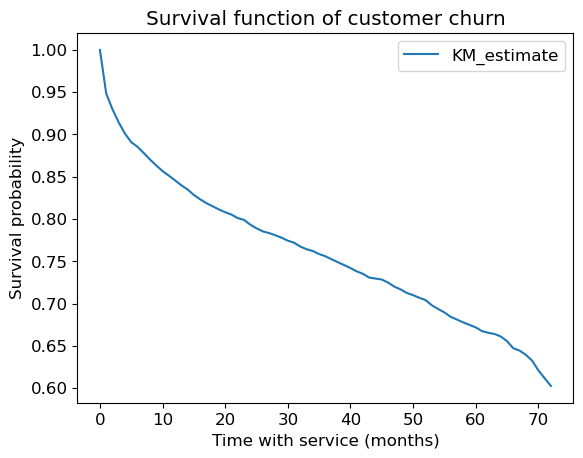

In [54]:
kmf.survival_function_.plot();
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- What is this plot telling us?
- It shows the probability of survival over time.
- For example, after 20 months the probability of survival is ~0.8. 
- Over time it's going down. 

What's the average tenure?

In [55]:
np.mean(train_df_surv["tenure"])

32.6391518364256

What's the average tenure of the people who churned?

In [56]:
np.mean(train_df_surv.query("Churn == 1.0")["tenure"])

17.854744525547446

What's the average tenure of the people who did not churn? 

In [57]:
np.mean(train_df_surv.query("Churn == 0.0")["tenure"])

37.816717791411044

- Let's look at the histogram of number of people who have not churned. 
- The key point here is that people _joined at different times_. 

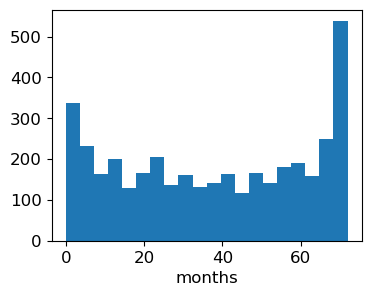

In [58]:
plt.figure(figsize=(4, 3))
train_df_surv[train_df_surv['Churn'] == 0]["tenure"].hist(bins=20, grid=False)
plt.xlabel("months");

- Since the data was collected at a fixed time and these are the people who hadn't yet churned, those with larger `tenure` values here must have joined earlier.

Lifelines can also give us some "error bars":

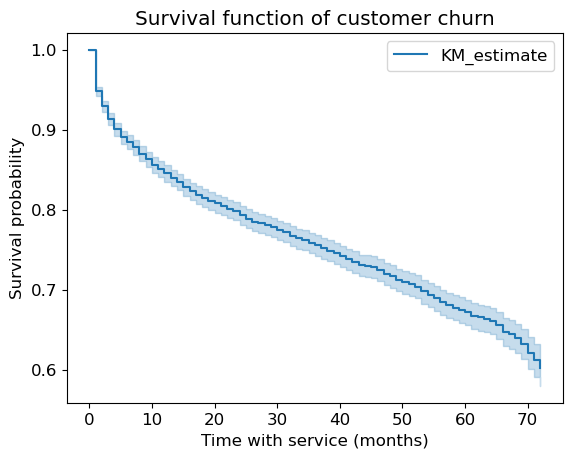

In [59]:
kmf.plot_survival_function()
plt.title("Survival function of customer churn")
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- We already have some actionable information here.
- The curve drops down fast at the beginning suggesting that people tend to leave early on. 
- If there would have been a big drop in the curve, it means a bunch of people left at that time (e.g., after a 1-month free trial). 
- By the way, the [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 57000 times!

We can also create the K-M curve for different subgroups:

In [60]:
T = train_df_surv["tenure"]
E = train_df_surv["Churn"]
senior = train_df_surv["SeniorCitizen"] == 1

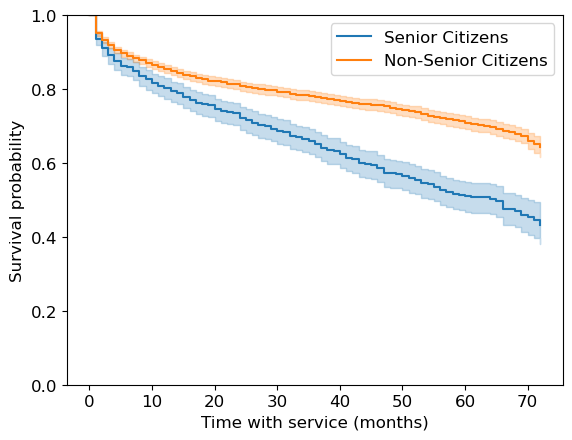

In [61]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot_survival_function(ax=ax)

plt.ylim(0, 1)
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- It looks like senior citizens churn more quickly than others.
- This is quite useful!

<br><br>

## Cox proportional hazards model

- We haven't been incorporating other features in the model so far. 
- The Cox proportional hazards model is a commonly used model that allows us to interpret how features influence a censored tenure/duration. 
- You can think of it like linear regression for survival analysis: we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (the proportional hazards assumption) that may not be true, but we won't go into this here.
- The proportional hazard model works multiplicatively, like linear regression with log-transformed targets.

In [62]:
cph = lifelines.CoxPHFitter()
# cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

- Ok, going to [this URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  - FYI this is related to switching from `LinearRegression` to `Ridge`.
  - Adding `drop='first'` on our OHE might have helped with this.
  - (For 340 folks: we're adding regularization; `lifelines` adds both L1 and L2 regularization, aka elastic net)

In [63]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(train_df_surv, duration_col="tenure", event_col="Churn");

We can look at the coefficients learned by the model and start interpreting them! 

In [64]:
cph_params = pd.DataFrame(cph.params_).sort_values(by="coef", ascending=False)
cph_params

,coef
covariate,
Contract_Month-to-month,0.812875
OnlineSecurity_No,0.311151
OnlineBackup_No,0.298561
PaymentMethod_Electronic check,0.280801
Partner_No,0.244814
...,...
OnlineBackup_Yes,-0.282600
PaymentMethod_Credit card (automatic),-0.302801
OnlineSecurity_Yes,-0.330346


How to interpret these coefficients In the Cox Proportional Hazards model? 
- A positive coefficient indicates that higher values of the feature are associated with higher hazard rates, meaning they are associated with worse survival.
- A negative coefficient indicates that higher values of the feature are associated with lower hazard rates, meaning they are associated with better survival.
- In our example, it looks like `Contract_Month-to-month` has a positive coefficient 
    - If the contract is month-to-month, it leads to more churn $\downarrow$ worse survival
- In our example, it looks like `Contract_Two year` has a negative coefficient 
    - If the contract is two-year contract, it leads to less churn $\downarrow$ better survival
    
This makes sense!!!

In [65]:
# cph.baseline_hazard_ # baseline hazard

In [66]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
SeniorCitizen,-0.019556,0.980634,0.057254,-0.131773,0.092660,0.876540,1.097088,0.0,-0.341571,0.732674,0.448757
MonthlyCharges,-0.003185,0.996820,0.040129,-0.081837,0.075467,0.921422,1.078387,0.0,-0.079377,0.936733,0.094290
Dependents_No,0.063772,1.065849,0.075042,-0.083308,0.210852,0.920067,1.234730,0.0,0.849812,0.395429,1.338508
Dependents_Yes,-0.063772,0.938219,0.075042,-0.210852,0.083308,0.809894,1.086877,0.0,-0.849812,0.395429,1.338508
OnlineSecurity_No,0.311151,1.364995,0.069644,0.174652,0.447650,1.190832,1.564631,0.0,4.467755,0.000008,16.948901
...,...,...,...,...,...,...,...,...,...,...,...
DeviceProtection_No,0.180214,1.197473,0.067879,0.047174,0.313254,1.048304,1.367868,0.0,2.654935,0.007932,6.978031
DeviceProtection_No internet service,-0.057267,0.944342,0.100970,-0.255165,0.140631,0.774789,1.150999,0.0,-0.567169,0.570599,0.809450
DeviceProtection_Yes,-0.154556,0.856795,0.069302,-0.290385,-0.018727,0.747975,0.981447,0.0,-2.230194,0.025735,5.280148


Could we have gotten this type of information out of sklearn?
- Yes, let's try it out! 
- But remember that using survival analysis approach is more appropriate for such problems. 

In [67]:
y_train.head()

6464     No
5707     No
3442     No
3932    Yes
6124     No
Name: Churn, dtype: object

In [68]:
X_train.drop(columns=["tenure"]).head()

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6464,4726-DLWQN,Male,1,No,No,Yes,Yes,DSL,Yes,Yes,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.60
5707,4537-DKTAL,Female,0,No,No,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.40
3442,0468-YRPXN,Male,0,No,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.10
3932,1304-NECVQ,Female,1,No,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55
6124,7153-CHRBV,Female,0,Yes,Yes,Yes,No,DSL,Yes,No,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35


I'm redefining feature types and our preprocessor for our sanity. 

In [69]:
numeric_features = ["MonthlyCharges"]
drop_features = ["customerID", "tenure", "TotalCharges"]
passthrough_features = ["SeniorCitizen"]
target_column = ["Churn"]
# the rest are categorical
categorical_features = list(
    set(train_df.columns)
    - set(numeric_features)
    - set(passthrough_features)
    - set(drop_features)
    - set(target_column)
)

In [70]:
preprocessor = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        numeric_features,
    ),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("passthrough", passthrough_features),
    ("drop", drop_features),
)

In [71]:
preprocessor.fit(X_train);

In [72]:
new_columns = (
    numeric_features
    + preprocessor.named_transformers_["onehotencoder"]
    .get_feature_names_out(categorical_features)
    .tolist()
    + passthrough_features
)

In [73]:
lr = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))
lr.fit(X_train, y_train)
lr_coefs = pd.DataFrame(
    data=np.squeeze(lr[1].coef_), index=new_columns, columns=["Coefficient"]
)

In [74]:
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
Contract_Month-to-month,1.117063
InternetService_Fiber optic,0.522513
OnlineSecurity_No,0.349206
PaymentMethod_Electronic check,0.311261
OnlineBackup_No,0.253954
...,...
MonthlyCharges,-0.172977
OnlineSecurity_Yes,-0.242936
PaymentMethod_Credit card (automatic),-0.260652
InternetService_DSL,-0.416242


- There is some agreement, which is good.
- But our survival model is much more useful.
  - Not to mention more correct.

- One thing we get with `lifelines` is confidence intervals on the coefficients:

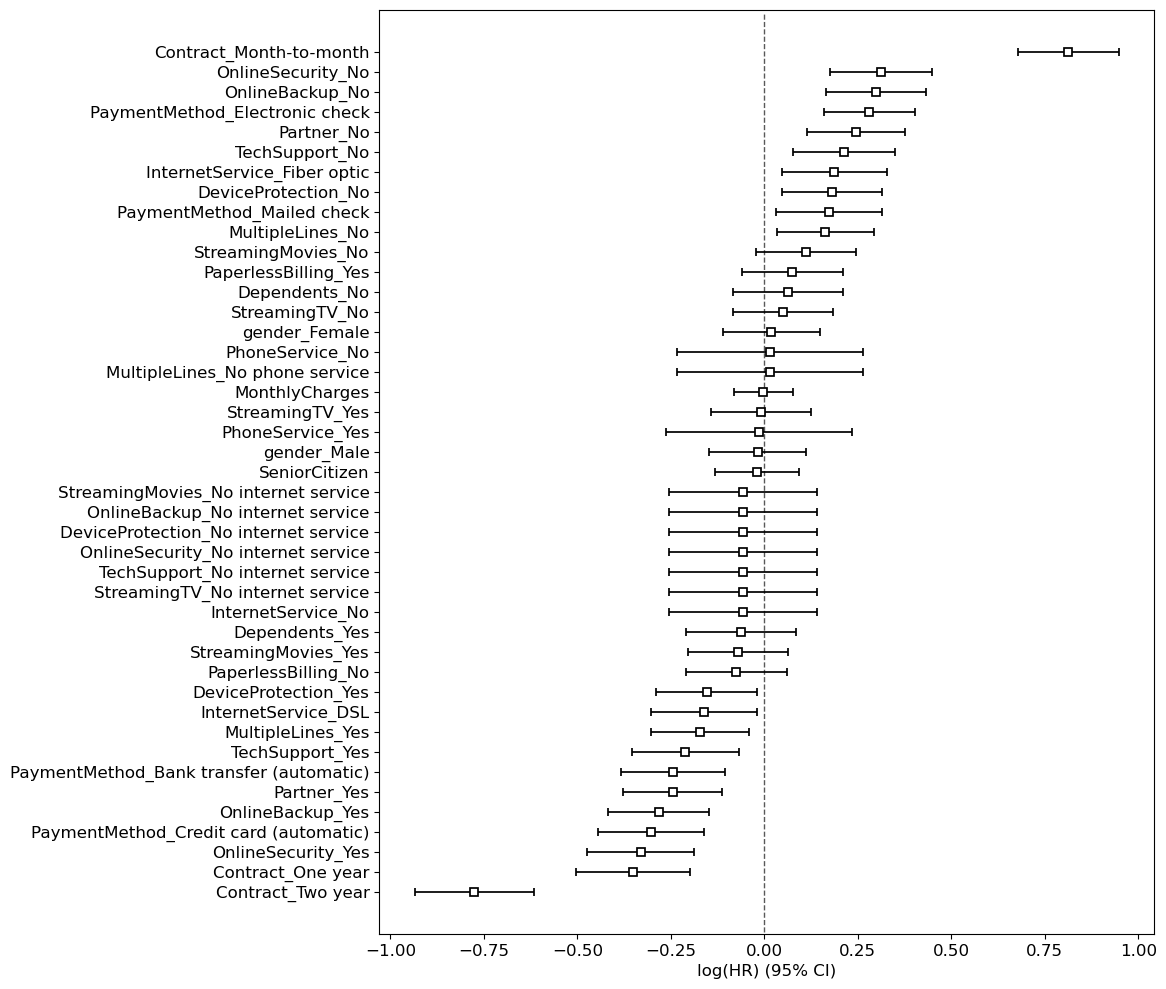

In [75]:
plt.figure(figsize=(10, 12))
cph.plot();

- (We could probably get the same for logistic regression if using `statsmodels` instead of sklearn.)
- However, in general, I would be careful with all of this.
- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.
- But I think it's very useful to know about survival analysis and the availability of software to deal with it.
- Oh, and there are lots of other nice plots.

### Survival plots

- Let's look at the survival plots for the people with 
    - two-year contract (Contract_Two year = 1) and 
    - people without two-year contract (Contract_Two year = 0)
- As expected, the former survive longer. 

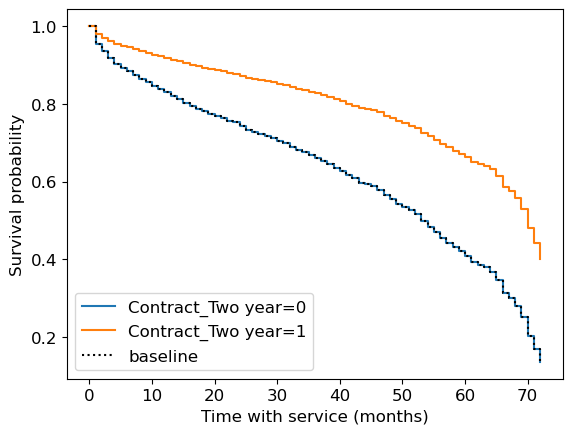

In [76]:
cph.plot_partial_effects_on_outcome("Contract_Two year", [0, 1]);
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

Now let's look at the survival plots for the people with different MonthlyCharges. 

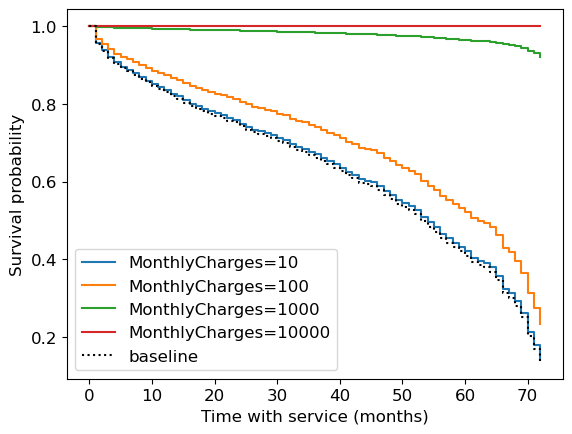

In [77]:
cph.plot_partial_effects_on_outcome("MonthlyCharges", [10, 100, 1000, 10_000]);
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

- That's the thing with linear models, they can't stop the growth.
- We have a negative coefficient associated with `MonthlyCharges`

In [78]:
cph_params.loc["MonthlyCharges"]

coef   -0.003185
Name: MonthlyCharges, dtype: float64

If your monthly charges are huge, it takes this to the extreme and thinks you'll basically never churn.

<br><br><br><br>

## Prediction

- We can use survival analysis to make predictions as well.
- Here is the expected number of months to churn for the first 5 customers in the test set:

In [79]:
test_X = test_df_surv.drop(columns=["tenure", "Churn"])

How long each non-churned customer is likely to stay according to the model assuming that they just joined right now?  

In [80]:
cph.predict_expectation(test_X).head()  # assumes they just joined right now

941     35.206724
1404    69.023086
5515    68.608565
3684    27.565062
7017    67.890933
dtype: float64

Survival curves for first 5 customers in the test set:

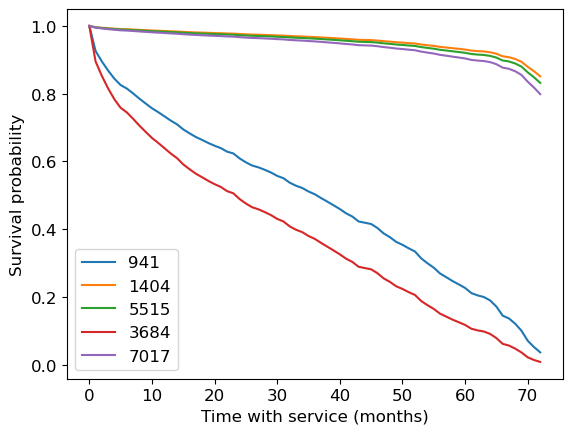

In [81]:
cph.predict_survival_function(test_X[:5]).plot()
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability");

From `predict_survival_function` documentation:

> Predict the survival function for individuals, given their covariates. This assumes that the individual just entered the study (that is, we do not condition on how long they have already lived for.) 

So these curves are "starting now".

- There's no probability prerequisite for this course, so this is optional material.
- But you can do some interesting stuff here with conditional probabilities.
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer. 
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

Let's get the customers who have not churned yet.  

In [82]:
train_df_surv_not_churned = train_df_surv[train_df_surv["Churn"] == 0]

We can _condition_ on the person having been around for 20 months.

In [83]:
cph.predict_survival_function(train_df_surv_not_churned[:1], conditional_after=20)

,6464
0.0,1.000000
1.0,0.996788
2.0,0.991966
3.0,0.989443
4.0,0.982570
...,...
68.0,0.429634
69.0,0.429634
70.0,0.429634
71.0,0.429634


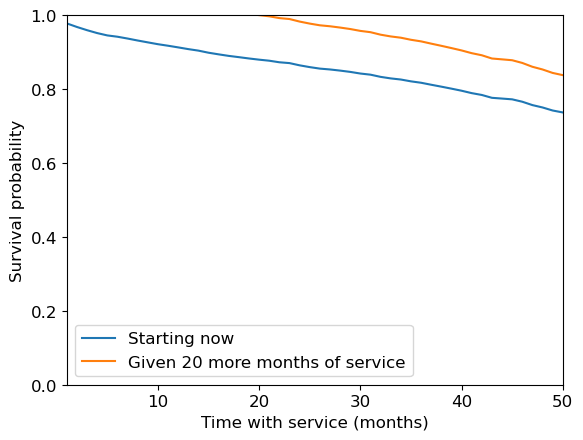

In [84]:
plt.figure()
cph.predict_survival_function(train_df_surv_not_churned[:1]).plot(ax=plt.gca())
preds = cph.predict_survival_function(
    train_df_surv_not_churned[:1], conditional_after=20
)
plt.plot(preds.index[20:], preds.values[:-20])
plt.xlabel("Time with service (months)")
plt.ylabel("Survival probability")
plt.legend(["Starting now", "Given 20 more months of service"])
plt.ylim([0, 1])
plt.xlim([1, 50]);

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 20 months.

- How long each non-churned customer is likely to stay according to the model assuming that they have been here for the tenure time? 
- So, we can set this to their actual tenure so far to get a prediciton of what will happen going forward:

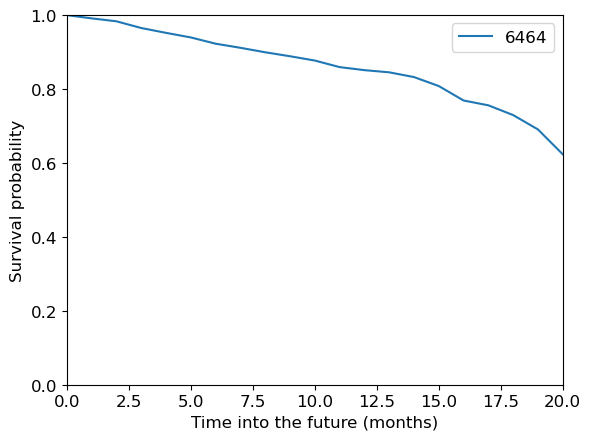

In [85]:
cph.predict_survival_function(
    train_df_surv_not_churned[:1],
    conditional_after=train_df_surv_not_churned[:1]["tenure"],
).plot()
plt.xlabel("Time into the future (months)")
plt.ylabel("Survival probability")
plt.ylim([0, 1])
plt.xlim([0, 20]);

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

<br><br>

## (Optional) Evaluation 

By default score returns "partial log likelihood":

In [86]:
cph.score(train_df_surv)

-1.8641864337292489

In [87]:
cph.score(test_df_surv)

-1.7277854625841886

We can look at the "concordance index" which is more interpretable:

In [88]:
cph.concordance_index_

0.8625888648969532

In [89]:
cph.score(train_df_surv, scoring_method="concordance_index")

0.8625888648969532

In [90]:
cph.score(test_df_surv, scoring_method="concordance_index")

0.8546143543902771

From the documentation [here](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-and-calibration-in-survival-regression):

> Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:
> 
> - 0.5 is the expected result from random predictions,
> - 1.0 is perfect concordance and,
> - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
> 
> [Here](https://stats.stackexchange.com/a/478305/11867) is an excellent introduction & description of the c-index for new users.


In [91]:
cph.log_likelihood_ratio_test()

<lifelines.StatisticalResult: log-likelihood ratio test>
null_distribution = chi squared
  degrees_freedom = 43
        test_name = log-likelihood ratio test

---
 test_statistic      p  -log2(p)
        2206.68 <0.005       inf

In [92]:
cph.check_assumptions(train_df_surv)

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 5282 total observations, 3912 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic      p  -log2(p)
Contract_Month-to-month                 km              0.07   0.80      0.33
                                        rank            0.00   0.97      0.04
Contract_One year                       km             14.52 <0.005     12.81
                                        rank           10.11 <0.005      9.41
Contract_Two year                       km              8.86 <0.005      8.42
                                        rank            7.69   0.01      7.49
Dependents_No                           km              0.07   0.79      0.34
                                        rank            0.07   0.79      0.34
Dependents_Yes                          km              0.07   0.79      0.34
                                        rank            0.07   0.79      0.34
DeviceProtection_No                     km              0.07   0.79      0.34
                                        rank            0.08   0.77      0.37
DeviceProtection_No internet service    km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
DeviceProtection_Yes                    km              0.70   0.40      1.31
                                        rank            0.76   0.38      1.38
InternetService_DSL                     km              0.32   0.57      0.81
                                        rank            0.28   0.59      0.75
InternetService_Fiber optic             km              1.02   0.31      1.68
                                        rank            0.98   0.32      1.64
InternetService_No                      km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
MonthlyCharges                          km              1.65   0.20      2.33
                                        rank            1.72   0.19      2.40
MultipleLines_No                        km              1.57   0.21      2.25
                                        rank            1.87   0.17      2.55
MultipleLines_No phone service          km              0.03   0.86      0.21
                                        rank            0.05   0.83      0.27
MultipleLines_Yes                       km              1.92   0.17      2.59
                                        rank            2.35   0.13      3.00
OnlineBackup_No                         km              0.29   0.59      0.76
                                        rank            0.24   0.63      0.68
OnlineBackup_No internet service        km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
OnlineBackup_Yes                        km              1.25   0.26      1.92
                                        rank            1.17   0.28      1.84
OnlineSecurity_No                       km              0.02   0.88      0.19
                                        rank            0.09   0.77      0.38
OnlineSecurity_No internet service      km              0.25   0.62      0.69
                                        rank            0.26   0.61      0.72
OnlineSecurity_Yes                      km              0.56   0.46      1.13
                                        rank            0.85   0.36      1.49
PaperlessBilling_No                     km              0.03   0.86      0.21
                                        rank            0.02   0.90      0.16
PaperlessBilling_Yes                    km              0.03   0.86      0.21
                                        rank            0.02   0.90      0.16
Partner_No                              km             



1. Variable 'Contract_One year' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_One year', ...]`
in the call in `.fit`. See documentation in link [E] below.

2. Variable 'Contract_Two year' failed the non-proportional test: p-value is 0.0029.

   Advice: with so few unique values (only 2), you can include `strata=['Contract_Two year', ...]`
in the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-f

[]

<br><br><br><br>

## Other approaches / what did we not cover? 

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

### Types of censoring
There are also various types and sub-types of censoring we didn't cover:

- What we did today is called "right censoring"
- Sub-types within right censoring
  - Did everyone join at the same time?
  - Other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## Summary

- Censoring and incorrect approaches to handling it
  - Throw away people who haven't churned
  - Assume everyone churns today
- Predicting tenure vs. churned
- Survival analysis encompasses both of these, and deals with censoring
- And it can make rich and interesting predictions!
- KM model -> doesn't look at features
- CPH model -> like linear regression, does look at the features

## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis